# Purpose
研究婚外情的數據

(1) 該位外遇的可能性有多大？ 
(2) 影響外遇的原因是什麼？ 
(3) 可以根據分析結果說明如何降低外遇的發生嗎？

# 數據說明

* 婚外情數據即著名的“Fair’s Affairs”，取自於1969年《今日心理》（Psychology Today）所做的一個代表性調查
* 該數據從601個參與者身上收集了9個變量
* 變數包括一年來婚外情的頻率以及參與者性別、年齡、婚齡、是否有小孩、宗教信仰程度、學歷、職業，還有對婚姻的自我評分

#### affairs 受訪者在過去一年中進行外遇的頻率         
0 = 無         
1 = 一次       
2 = 兩次         
3 = 三次        
7 = 4 - 10 次         
12 = 每月或更多         

#### gender          
0 = 女性         
1 = 男性         

#### age         
17.5 = 20 歲以下         
22.0 = 20 - 24         
27.0 = 25 - 29         
32.0 = 30 - 34         
37.0 = 35 - 39         
42.0 = 40 - 44         
47.0 = 45 - 49         
52.0 = 50 - 54         
57.0 = 55 或以上         

#### yearsmarried  婚姻時間                  
0.125 = 3 個月或更短         
0.417 = 4 - 6 個月         
0.750 = 6 個月 - 1 年         
1.500 = 1 - 2 年         
4.000 = 3 - 5 年         
7.000 = 6 - 8 年         
10.00 = 9 - 11 年         
15.00 = 12 年或更長時間         

#### children 孩子人數                  
0 = 無         
1 = 一個或多個         
         
#### religiousness 婚內的宗教信仰         
1 = 反宗教         
2 = 完全沒有         
3 = 輕微         
4 = 有點         
5 = 非常         

#### education 教育程度         
9.0 = 小學         
12.0 = 高中畢業         
14.0 = 一些大學         
16.0 = 大學畢業生         
17.0 = 一些畢業作品         
18.0 = 碩士學位         
20.0 = 博士、醫學博士或其他高級學位 

#### occupation 詳見data-descriptions.pdf

#### rating 對婚姻的自我評分 (5分制，1表示非常不幸福，5表示非常幸福）         

# 1. import data

In [12]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [13]:
df = pd.read_csv('Affairs.csv')
# 2. 型別確認與基本資訊
print("--- 資料型別檢查 ---")
df.head()

--- 資料型別檢查 ---


,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,0,male,37.0,10.00,no,3,18,7,4
1,0,female,27.0,4.00,no,4,14,6,4
2,0,female,32.0,15.00,yes,1,12,1,4
3,0,male,57.0,15.00,yes,5,18,6,5
4,0,male,22.0,0.75,no,2,17,6,3


In [14]:
df.isnull().sum()

affairs          0
gender           0
age              0
yearsmarried     0
children         0
religiousness    0
education        0
occupation       0
rating           0
dtype: int64

In [15]:
# ↑由上可知，此資料集沒有缺失值
# 缺失值處理
# 數值型用平均值補缺失
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# 類別型用眾數補缺失
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


### <span style="color:#3498DB">Point: 請先將affairs變數轉為二值型因子'ynaffair'，外遇0次為0，外遇一次以上為1</span>

In [16]:
# 轉換目標：
# 只要次數 > 0，就當作 1 (有)；
# 次數 = 0，就當作 0 (沒有)
df['ynaffairs'] = df['affairs'].apply(lambda x: 1 if x > 0 else 0)

# 看看資料前五筆
print(df.head())

   affairs  gender   age  yearsmarried children  religiousness  education  \
0        0    male  37.0         10.00       no              3         18   
1        0  female  27.0          4.00       no              4         14   
2        0  female  32.0         15.00      yes              1         12   
3        0    male  57.0         15.00      yes              5         18   
4        0    male  22.0          0.75       no              2         17   

   occupation  rating  ynaffairs  
0           7       4          0  
1           6       4          0  
2           1       4          0  
3           6       5          0  
4           6       3          0  


In [17]:
# 把文字轉成數字 0 和 1
# drop_first=True 是為了避免「虛擬變數陷阱」，只留一欄就能代表兩種狀態
df_final = pd.get_dummies(df, columns=['gender', 'children'], drop_first=True, dtype=int)

# 移除原本的 affairs 次數欄位，留下我們要預測的 affairs_binary
# 定義 X (特徵) 與 y (目標)
X = df_final.drop(['affairs', 'ynaffairs'], axis=1) # 題目
y = df_final['ynaffairs'] # 答案
print(df_final.head())

   affairs   age  yearsmarried  religiousness  education  occupation  rating  \
0        0  37.0         10.00              3         18           7       4   
1        0  27.0          4.00              4         14           6       4   
2        0  32.0         15.00              1         12           1       4   
3        0  57.0         15.00              5         18           6       5   
4        0  22.0          0.75              2         17           6       3   

   ynaffairs  gender_male  children_yes  
0          0            1             0  
1          0            0             0  
2          0            0             1  
3          0            1             1  
4          0            1             0  


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler





# 定義變數與數據縮放
# 數據標準化

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 切分 80% 訓練集與 20% 測試集
# random_state=42 就是我們之前說的「隨機種子」，確保每次結果一樣
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [19]:
# Logistic Regression

model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 績效評估與風險鑑定
# 對於分類問題，我們除了看準確度（Accuracy），更要看混淆矩陣 (Confusion Matrix)

# 1. 進行預測
predictions = model.predict(X_test)

# 2. 評估表現
print(f"準確度 (Accuracy): {accuracy_score(y_test, predictions):.4f}")
print("\n詳細分類報告：")
print(classification_report(y_test, predictions))

# 3. 找出影響外遇的核心風險因子
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\n--- 影響因子分析 (係數愈大，代表發生機率愈高) ---")
print(importance)

準確度 (Accuracy): 0.7521

詳細分類報告：
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        91
           1       0.50      0.23      0.32        30

    accuracy                           0.75       121
   macro avg       0.64      0.58      0.58       121
weighted avg       0.71      0.75      0.72       121


--- 影響因子分析 (係數愈大，代表發生機率愈高) ---
         Feature  Coefficient
1   yearsmarried     0.382245
4     occupation     0.153203
7   children_yes     0.132374
6    gender_male     0.043328
3      education    -0.026965
0            age    -0.220616
2  religiousness    -0.413841
5         rating    -0.579235


Text(0.5, 25.52222222222222, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

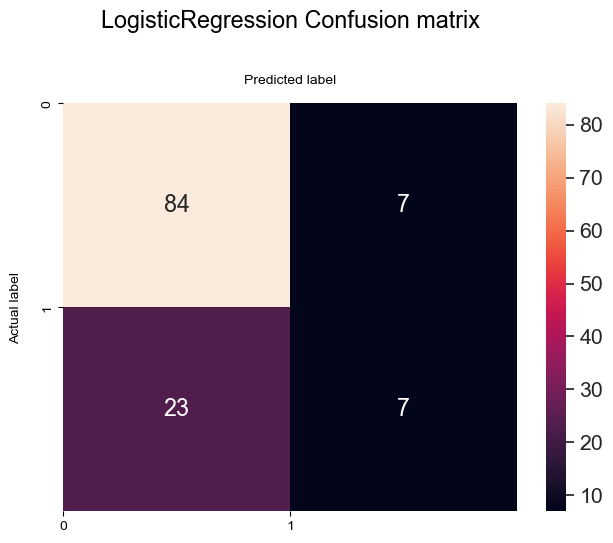

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Create the Confusion matrix
cm = confusion_matrix(y_test, predictions) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('LogisticRegression Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [22]:
TP=18; FP=37; FN=12; TN=54

print(f'Accuracy : {round((TP+TN)/(TP+FP+TN+FN),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((TP)/(TP+FP), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((TP)/(TP+FN), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((TN)/(TN+TP), 3)}')            # TN / (TN + FP)

Accuracy : 0.595
Precision : 0.327
Recall/Sensitivity : 0.6
Specificity : 0.75


Axes(0.125,0.11;0.775x0.77)


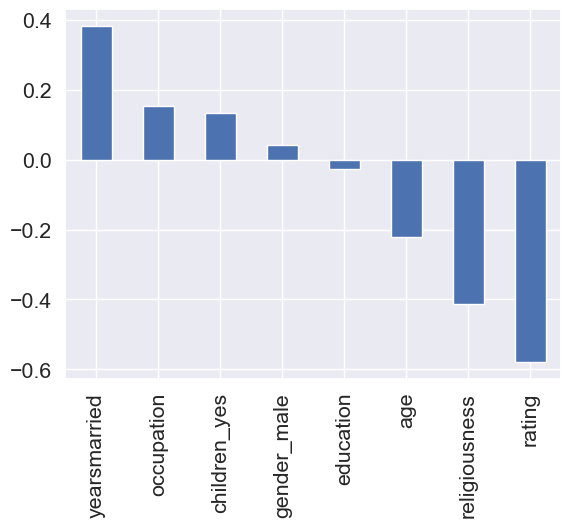

In [23]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0], index=X.columns.values)
print (weights.sort_values(ascending = False)[:15].plot(kind='bar'))

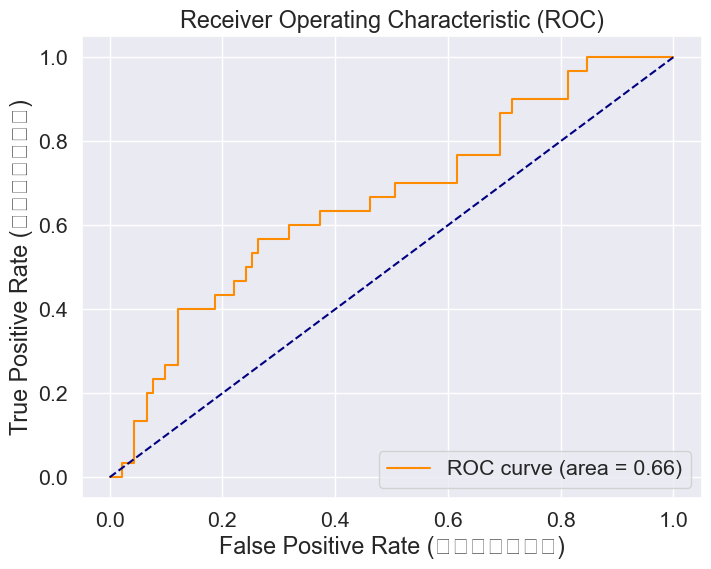

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. 取得模型預測的「機率值」（而非直接 0 或 1）
y_probs = model.predict_proba(X_test)[:, 1]

# 2. 計算 ROC 數值
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# 3. 繪圖
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # 隨機猜測線
plt.xlabel('False Positive Rate (冤枉好人的比例)')
plt.ylabel('True Positive Rate (抓到風險的比例)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Suppert Vector Machine

In [25]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

model_svm = SVC(kernel='rbf', probability=True, random_state=42) 
model_svm.fit(X_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 進行預測
y_pred_svm = model_svm.predict(X_test)
metrics.accuracy_score(y_test, y_pred_svm)
# 2. 顯示報表
print(f"SVM 準確度: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nSVM 分類報告：")
print(classification_report(y_test, y_pred_svm))


SVM 準確度: 0.7355

SVM 分類報告：
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        91
           1       0.40      0.13      0.20        30

    accuracy                           0.74       121
   macro avg       0.58      0.53      0.52       121
weighted avg       0.68      0.74      0.68       121



Text(0.5, 15.049999999999999, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

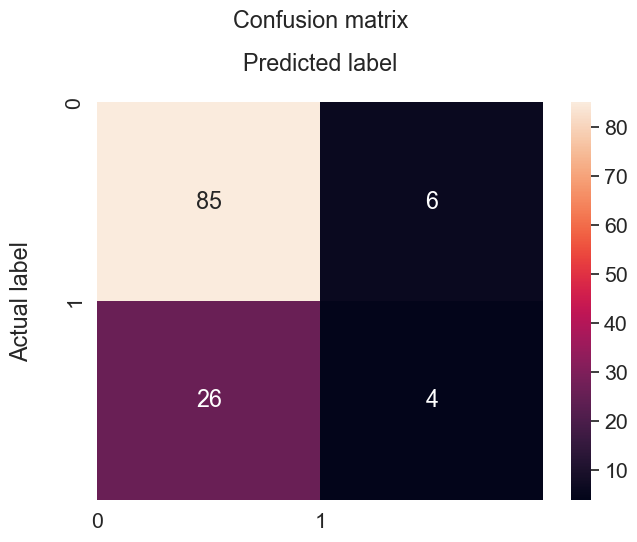

In [27]:

# Create the Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [28]:
TP=4; FP=6; FN=26; TN=85

print(f'Accuracy : {round((TP+TN)/(TP+FP+TN+FN),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((TP)/(TP+FP), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((TP)/(TP+FN), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((TN)/(TN+TP), 3)}')            # TN / (TN + FP)

Accuracy : 0.736
Precision : 0.4
Recall/Sensitivity : 0.133
Specificity : 0.955


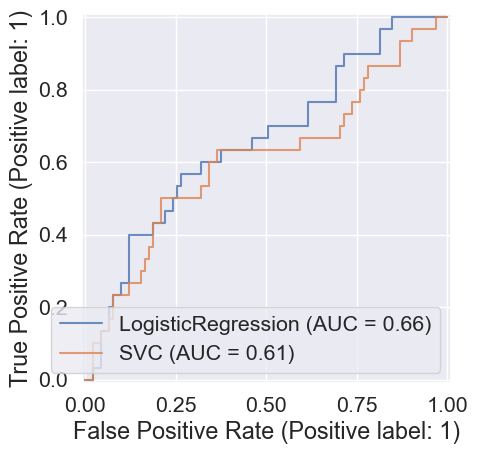

In [29]:
from sklearn.metrics import RocCurveDisplay



ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
svm_disp = RocCurveDisplay.from_estimator(model_svm, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [30]:
# Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model_dt = DecisionTreeClassifier(criterion = 'gini')  # CART, 默認為gini


In [37]:
model_dt = DecisionTreeClassifier(
    criterion='gini',         # 1. 衡量標準：'gini' (吉尼係數) 或 'entropy' (資訊熵)
    max_depth=5,              # 2. 最大深度：防止樹長太深，建議設在 3~10 之間
    min_samples_split=10,     # 3. 分裂所需最小樣本數：數值越大，樹越簡單
    min_samples_leaf=5,       # 4. 葉節點最小樣本數：避免產生只包含極少數樣本的葉子
    max_features='sqrt',      # 5. 考慮的最大特徵數：'sqrt', 'log2' 或 None (全部)
    random_state=42
)
clf = model_dt.fit(X_train, y_train)

In [38]:
# Make predictions
y_test_pred_dt = model_dt.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_dt))

0.7107438016528925


Text(0.5, 15.049999999999999, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

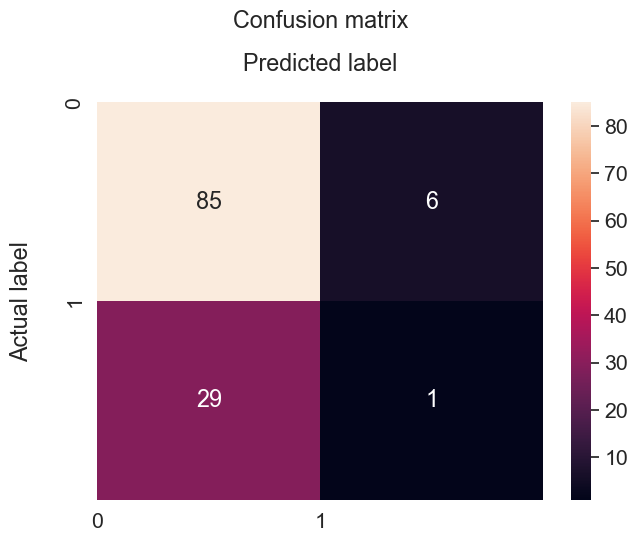

In [39]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_dt) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [60]:
preprocessor = make_pipeline(SelectKBest(f_classif, k=5)) # 挑選出K個分數最高的特徵
DecisionTree = make_pipeline(preprocessor,DecisionTreeClassifier(random_state=42))

In [61]:
DecisionTree.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'pipeline', 'decisiontreeclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__transform_input', 'pipeline__verbose', 'pipeline__selectkbest', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__monotonic_cst', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

In [62]:
hyper_params_dt = {
    'decisiontreeclassifier__max_leaf_nodes':[10,20,30],    # 最多有多少個leaf nodes
    'decisiontreeclassifier__min_samples_leaf': [5,10,15],  # 要成為leaf nodes，最少需要多少資料
    'decisiontreeclassifier__max_depth': [5,10,15]          # 限制樹的高度最多幾層
}

In [63]:
# 使用 GridSearch 自動尋找「Recall（召回率）」最高的組合
grid_dt = GridSearchCV(DecisionTree, hyper_params_dt, scoring='recall', cv=3)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

{'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__max_leaf_nodes': 10, 'decisiontreeclassifier__min_samples_leaf': 15}


In [64]:
y_test_pred_griddt = grid_dt.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred_griddt)

0.71900826446281

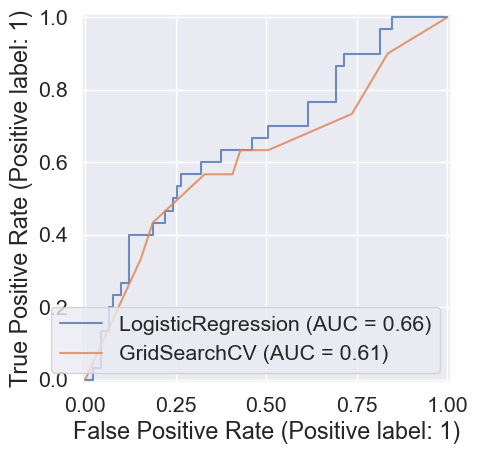

In [45]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
grid_dt_disp = RocCurveDisplay.from_estimator(grid_dt, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [46]:
# Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
y_test_pred_rf = model_rf.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_rf))

0.743801652892562


Text(0.5, 15.049999999999999, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

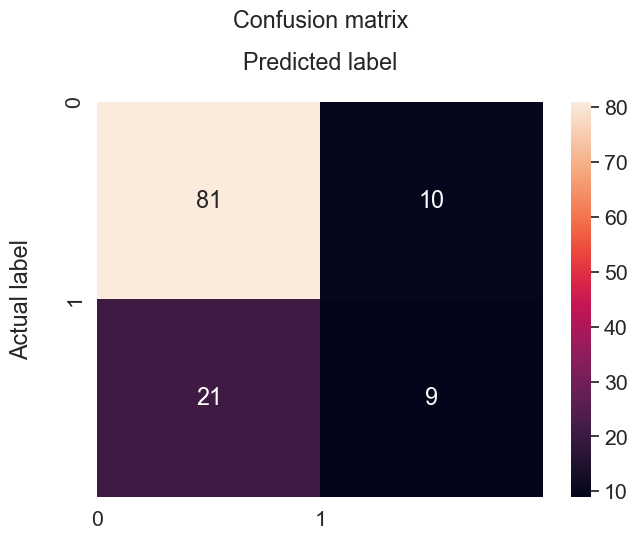

In [48]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_rf) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [49]:
TP=7; FP=10; FN=23; TN=81

print(f'Accuracy : {round((TP+TN)/(TP+FP+TN+FN),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((TP)/(TP+FP), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((TP)/(TP+FN), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((TN)/(TN+TP), 3)}')            # TN / (TN + FP)

Accuracy : 0.727
Precision : 0.412
Recall/Sensitivity : 0.233
Specificity : 0.92


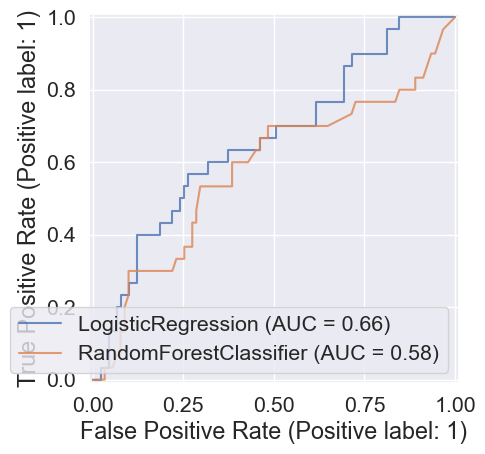

In [50]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
model_rf_disp = RocCurveDisplay.from_estimator(model_rf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [51]:
# XGboost

In [52]:
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)
y_test_pred_xg = model_xg.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred_xg)

0.6859504132231405

Text(0.5, 15.049999999999999, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

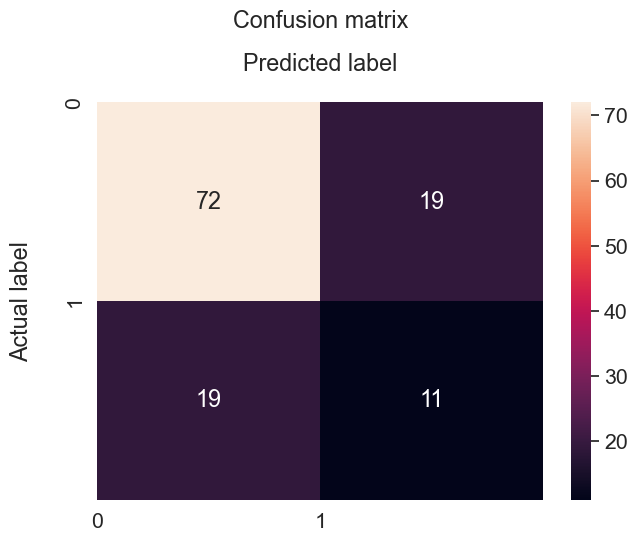

In [53]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_xg) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [54]:
TP=11; FP=19; FN=29; TN=72

print(f'Accuracy : {round((TP+TN)/(TP+FP+TN+FN),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((TP)/(TP+FP), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((TP)/(TP+FN), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((TN)/(TN+TP), 3)}')            # TN / (TN + FP)

Accuracy : 0.634
Precision : 0.367
Recall/Sensitivity : 0.275
Specificity : 0.867


In [67]:
#Logistic Regression

# 建立模型並開始學習
# 建立邏輯回歸模型
model = LogisticRegression(
                            penalty='l2',        # 1. 正則化類型：可改為 'l1', 'l2', 'elasticnet', 或 None
                            C=1.0,               # 2. 正則化強度：數值越小，正則化越強（模型越簡單）。可以試試 0.1, 10, 100
                            solver='lbfgs',      # 3. 優化演算法：若 penalty='l1'，則須改用 'liblinear' 或 'saga'
                            max_iter= 1000,       # 4. 最大迭代次數：若模型不收斂（報錯），需調大此值
                            )

model.fit(X_train, y_train)
predictions = model.predict(X_test)
# 找出影響外遇的核心風險因子
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\n--- 影響因子分析 (係數愈大，代表發生機率愈高) ---")
print(importance)
print("="*80)
print(f"Logistic Regression準確度 (Accuracy): {accuracy_score(y_test, predictions):.4f}")



#Suppert Vector Machine
model_svm = SVC(kernel='rbf', probability=True, random_state=42) 
model_svm.fit(X_train,y_train)
y_pred_svm = model_svm.predict(X_test)
metrics.accuracy_score(y_test, y_pred_svm)
print(f"SVM 準確度: {accuracy_score(y_test, y_pred_svm):.4f}")



# Decision Tree
model_dt = DecisionTreeClassifier(
    criterion='gini',         # 1. 衡量標準：'gini' (吉尼係數) 或 'entropy' (資訊熵)，CART, 默認為gini
    max_depth=5,              # 2. 最大深度：防止樹長太深，建議設在 3~10 之間
    min_samples_split=10,     # 3. 分裂所需最小樣本數：數值越大，樹越簡單
    min_samples_leaf=5,       # 4. 葉節點最小樣本數：避免產生只包含極少數樣本的葉子
    max_features='sqrt',      # 5. 考慮的最大特徵數：'sqrt', 'log2' 或 None (全部)
    random_state=42
)
clf = model_dt.fit(X_train, y_train)
# Make predictions
y_test_pred_dt = model_dt.predict(X_test)
print(f"Decision Tree 準確度:{accuracy_score(y_test, y_test_pred_dt):.4f}")
# 建立pipeline
preprocessor = make_pipeline(SelectKBest(f_classif, k=5)) # 挑選出K個分數最高的特徵
DecisionTree = make_pipeline(preprocessor,DecisionTreeClassifier(random_state=42))
hyper_params_dt = {
    'decisiontreeclassifier__max_leaf_nodes':[10,20,30],    # 最多有多少個leaf nodes
    'decisiontreeclassifier__min_samples_leaf': [5,10,15],  # 要成為leaf nodes，最少需要多少資料
    'decisiontreeclassifier__max_depth': [5,10,15]          # 限制樹的高度最多幾層
}
# 使用 GridSearch 自動尋找「Recall（召回率）」最高的組合
grid_dt = GridSearchCV(DecisionTree, hyper_params_dt, scoring='recall', cv=3)
grid_dt.fit(X_train, y_train)

y_test_pred_griddt = grid_dt.predict(X_test)
print(f"網格搜索優化後準確度:{accuracy_score(y_test, y_test_pred_griddt):.4f}")


# Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
# Make predictions
y_test_pred_rf = model_rf.predict(X_test)
print(f"Random Forest 準確度: {accuracy_score(y_test, y_test_pred_rf):.4f}")




# XGBoost
model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)
y_test_pred_xg = model_xg.predict(X_test)
print(f"Xgboost 準確度: {accuracy_score(y_test, y_test_pred_xg):.4f}")



--- 影響因子分析 (係數愈大，代表發生機率愈高) ---
         Feature  Coefficient
1   yearsmarried     0.382245
4     occupation     0.153203
7   children_yes     0.132374
6    gender_male     0.043328
3      education    -0.026965
0            age    -0.220616
2  religiousness    -0.413841
5         rating    -0.579235
Logistic Regression準確度 (Accuracy): 0.7521
SVM 準確度: 0.7355
Decision Tree 準確度:0.7107
網格搜索優化後準確度:0.7190
Random Forest 準確度: 0.7190
Xgboost 準確度: 0.6860


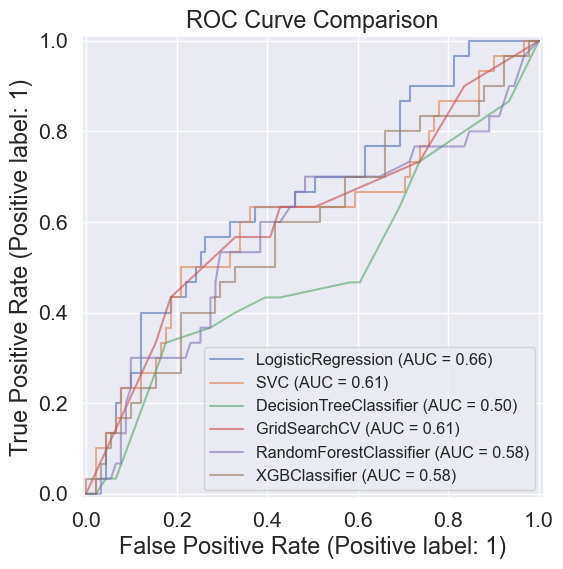

In [55]:
from sklearn.metrics import RocCurveDisplay
plt.figure(figsize=(8, 6))
ax = plt.gca()

log_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.6)
svm_disp = RocCurveDisplay.from_estimator(model_svm, X_test, y_test, ax=ax, alpha=0.6)
model_dt_disp = RocCurveDisplay.from_estimator(model_dt, X_test, y_test, ax=ax, alpha=0.6)
grid_dt_disp = RocCurveDisplay.from_estimator(grid_dt, X_test, y_test, ax=ax, alpha=0.6)
model_rf_disp = RocCurveDisplay.from_estimator(model_rf, X_test, y_test, ax=ax, alpha=0.6)
model_xg_disp = RocCurveDisplay.from_estimator(model_xg, X_test, y_test, ax=ax, alpha=0.6)


plt.legend(fontsize='x-small', loc='lower right')
plt.title('ROC Curve Comparison')
plt.show()